## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [17]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import os
import pickle

from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
from itertools import chain
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import InceptionV3
from keras import Sequential
from keras.layers import Concatenate
from keras import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import load_model
from sklearn.metrics import classification_report, roc_curve, auc, roc_auc_score, precision_recall_curve

from keras.layers import MaxPooling2D, Dense, Dropout

##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.

# Bringing the Data to EDA-Spec

In [18]:
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
98611,00026072_015.png,Atelectasis|Consolidation,15,26072,35,M,PA,2992,2991,0.143,0.143,NaN,/data/images_011/images/00026072_015.png
57691,00014296_002.png,No Finding,2,14296,69,F,AP,2500,2048,0.168,0.168,NaN,/data/images_007/images/00014296_002.png
76777,00018863_000.png,No Finding,0,18863,25,M,PA,2992,2989,0.143,0.143,NaN,/data/images_009/images/00018863_000.png


In [19]:
data = all_xray_df
colnames = ['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID',
       'Patient Age', 'Patient Gender', 'View Position', 'OriginalImage[Width',
       'Height]', 'OriginalImagePixelSpacing[x', 'y]', 'path']
data = data[colnames]

In [20]:
colnames = ['ImageIndex', 'FindingLabels', 'FollowUpNum', 'PatientID',
       'PatientAge', 'PatientGender', 'ViewPosition', 'OriginalImageWidth',
       'OriginalImageHeight', 'OriginalImagePixelSpacingX', 'OriginalImagePixelSpacingY', 'ImgPath']
data.columns = colnames

data.columns

Index(['ImageIndex', 'FindingLabels', 'FollowUpNum', 'PatientID', 'PatientAge',
       'PatientGender', 'ViewPosition', 'OriginalImageWidth',
       'OriginalImageHeight', 'OriginalImagePixelSpacingX',
       'OriginalImagePixelSpacingY', 'ImgPath'],
      dtype='object')

In [21]:
label_arrays = data['FindingLabels'].map(lambda x: x.split('|'))
distinct_labels = np.unique(list(chain(*label_arrays)))

for label in distinct_labels:
    vals = [label in array for array in label_arrays]
    data.insert(len(data.columns), label, vals)
    
data.sample(5)

,ImageIndex,FindingLabels,FollowUpNum,PatientID,PatientAge,PatientGender,ViewPosition,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacingX,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
101291,00026908_002.png,Pneumonia,2,26908,63,M,AP,3056,2544,0.139,...,False,False,False,False,False,False,False,False,True,False
81061,00019911_004.png,Nodule,4,19911,51,M,PA,2992,2991,0.143,...,False,False,False,False,False,False,True,False,False,False
77015,00018921_031.png,Infiltration,31,18921,43,F,AP,2500,2048,0.168,...,False,False,False,True,False,False,False,False,False,False
98015,00025849_059.png,Infiltration,59,25849,58,M,AP,3056,2544,0.139,...,False,False,False,True,False,False,False,False,False,False
11472,00003019_000.png,Infiltration,0,3019,58,M,PA,2992,2991,0.143,...,False,False,False,True,False,False,False,False,False,False


In [22]:
colnames = ['ImageIndex', 'FindingLabels', 'FollowupNum', 'PatientID', 'PatientAge',
       'PatientGender', 'ViewPosition', 'OriginalImageWidth',
       'OriginalImageHeight', 'OriginalImagePixelSpacingX',
       'OriginalImagePixelSpacingY', 'ImgPath', 'Atelectasis', 'Cardiomegaly',
       'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia',
       'Infiltration', 'Mass', 'No_Finding', 'Nodule', 'Pleural_Thickening',
       'Pneumonia', 'Pneumothorax']
data.columns = colnames

cols = ['ImageIndex', 'FollowupNum', 'PatientID', 'PatientAge',
       'PatientGender', 'ViewPosition', 'OriginalImageWidth',
       'OriginalImageHeight', 'OriginalImagePixelSpacingX',
       'OriginalImagePixelSpacingY', 'ImgPath', 'Atelectasis', 'Cardiomegaly',
       'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia',
       'Infiltration', 'Mass', 'No_Finding', 'Nodule', 'Pleural_Thickening',
       'Pneumonia', 'Pneumothorax']
data = data[cols]

data.PatientGender = data.PatientGender.astype('category')

## Removing Unwanted Values

Based on EDA we are going to remove patients over 90 years of age and anyone with more than 3 conditions on a scan, who we will deem as patients with "Multiple pre-existing conditions."

In [23]:
data = data[data.PatientAge <= 90]

conditions = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema',
       'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration',
       'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia',
       'Pneumothorax']

data['ConditionsCount'] = data[conditions].astype(int).sum(axis=1)
data = data[data.ConditionsCount < 4]

## Defining the Positive and Negative Classes

In [24]:
positives = ['Pneumonia', 'Consolidation', 'Infiltration']
data["Pneumonia_Like"] = data[positives].sum(axis=1) > 0

pos_data = data[data.Pneumonia_Like == True]
neg_data = data[data.No_Finding == True]
non_pos_data = data[(data.Pneumonia_Like == False) & (data.No_Finding == False)]

## Creating Testing, Training, and Validation Sets:

In [25]:
n_pos = len(pos_data)
n_neg = len(data[data.No_Finding])
n_non_pos = len(data[(data.No_Finding == False) & (data.Pneumonia_Like == False)])
n_total = len(data)
names = ['Positives', 'Negatives', 'Non-Positives', 'All']
counts = [n_pos, n_neg, n_non_pos, n_total]

for i in range(len(names)):
    print(f"{names[i]}: {counts[i]}")

Positives: 22662
Negatives: 60332
Non-Positives: 27443
All: 110437


In [26]:
pos_rate = n_pos / n_total
neg_rate = n_neg / n_total
non_pos_rate = n_non_pos / n_total
rates = [pos_rate, neg_rate, non_pos_rate]

for i in range(len(rates)):
    print(f"{names[i]}: {rates[i]}")

Positives: 0.2052029663971314
Negatives: 0.546302416762498
Non-Positives: 0.24849461684037052


In [27]:
train_split = 0.85
pos_train_size = int(n_pos * train_split)
pos_valid_size = n_pos - pos_train_size

print(f"Positives\nTraining: {pos_train_size} | Validation: {pos_valid_size}")

Positives
Training: 19262 | Validation: 3400


In [28]:
total_valid_size = pos_valid_size / pos_rate

neg_train_size = pos_train_size
neg_valid_size = int(total_valid_size * neg_rate)

non_pos_valid_size = int(total_valid_size * non_pos_rate)

print(f"Total Validation Set\n{int(total_valid_size)}")
print(f"\nPositives\nTraining: {pos_train_size} | Validation: {pos_valid_size}")
print(f"\nNegatives\nTraining: {neg_train_size} | Validation: {neg_valid_size}")
print(f"\nNon-Positives\nValidation: {non_pos_valid_size}")
print("\nSum validation sets: " + str(sum([pos_valid_size, neg_valid_size, non_pos_valid_size])))

Total Validation Set
16568

Positives
Training: 19262 | Validation: 3400

Negatives
Training: 19262 | Validation: 9051

Non-Positives
Validation: 4117

Sum validation sets: 16568


In [29]:
# Splitting into train and test sets
pos_train, pos_val = train_test_split(pos_data, 
                                      train_size=pos_train_size,
                                      test_size=pos_valid_size)

neg_train, neg_val = train_test_split(neg_data,
                                     train_size=neg_train_size,
                                     test_size=neg_valid_size)

non_pos_val = non_pos_data.sample(non_pos_valid_size)

train_data = pd.concat([pos_train, neg_train])
test_data = pd.concat([pos_val, neg_val.sample(pos_valid_size)])
val_data = pd.concat([pos_val, neg_val, non_pos_val])

print(f"Train Size: {len(train_data)} | Test Size: {len(test_data)} | Validation Size: {len(val_data)}")

Train Size: 38524 | Test Size: 6800 | Validation Size: 16568


# Training

## Data Augmentation

In [30]:
idg = ImageDataGenerator(rescale=1. / 255.0,
                         horizontal_flip = True, 
                         vertical_flip = False, 
                         height_shift_range = 0.1, 
                         width_shift_range = 0.1, 
                         rotation_range = 20, 
                         shear_range = 0.0,
                         zoom_range= 0.3
                        )

val_idg = ImageDataGenerator(rescale=1. / 255.0)

## Data Generators

In [31]:
IMG_SIZE = (299, 299)

train_gen = idg.flow_from_dataframe(dataframe=train_data, 
                                    directory=None, 
                                    color_mode = 'rgb',
                                    x_col = 'ImgPath',
                                    y_col = 'Pneumonia_Like',
                                    class_mode = 'raw',
                                    target_size = IMG_SIZE, 
                                    batch_size = 32,
                                    shuffle = True
                                    )

test_gen = val_idg.flow_from_dataframe(dataframe=test_data, 
                                    directory=None, 
                                    color_mode = 'rgb',
                                    x_col = 'ImgPath',
                                    y_col = 'Pneumonia_Like',
                                    class_mode = 'raw',
                                    target_size = IMG_SIZE, 
                                    batch_size = 32,
                                    shuffle = True
                                    )

val_test_gen = val_idg.flow_from_dataframe(dataframe=test_data, 
                                    directory=None, 
                                    color_mode = 'rgb',
                                    x_col = 'ImgPath',
                                    y_col = 'Pneumonia_Like',
                                    class_mode = 'raw',
                                    target_size = IMG_SIZE, 
                                    batch_size = 32,
                                    shuffle = False
                                    )

val_gen = val_idg.flow_from_dataframe(dataframe=val_data, 
                                    directory=None, 
                                    color_mode = 'rgb',
                                    x_col = 'ImgPath',
                                    y_col = 'Pneumonia_Like',
                                    class_mode = 'raw',
                                    target_size = IMG_SIZE, 
                                    batch_size = 32,
                                    shuffle = False
                                    )

Found 38524 validated image filenames.
Found 6800 validated image filenames.
Found 6800 validated image filenames.
Found 16568 validated image filenames.


## Augmentation Visualization

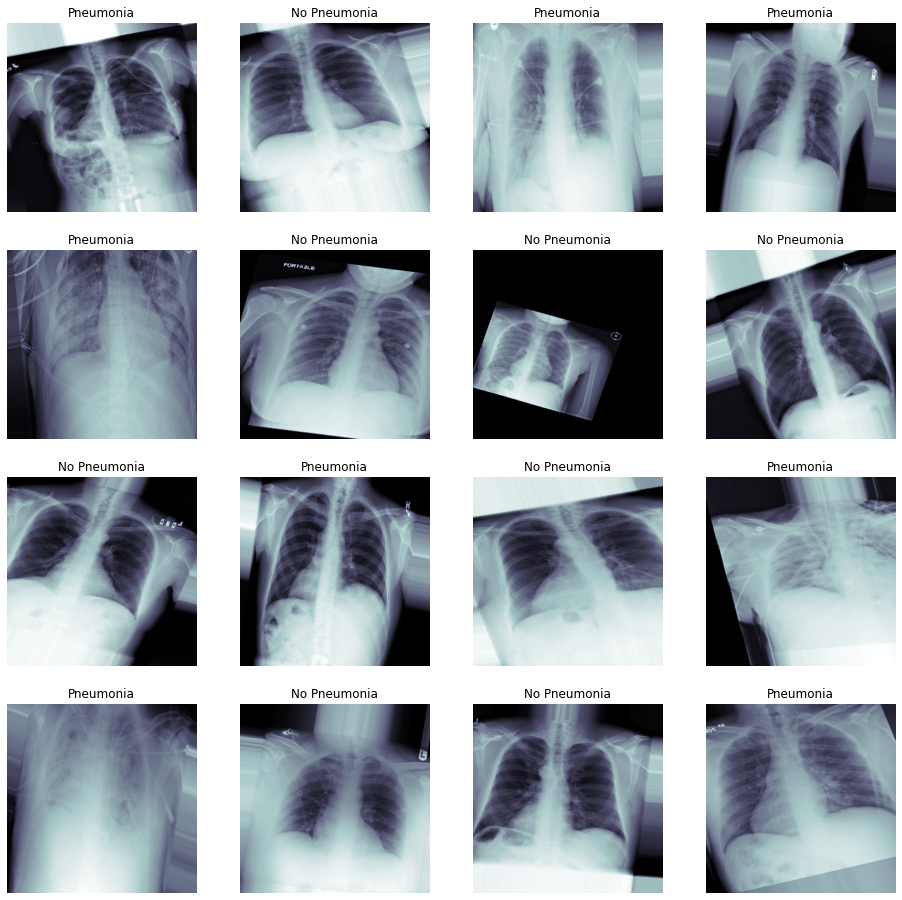

In [16]:
t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Model Loading

In [17]:
base_model = InceptionV3(
    include_top=False,
    weights="imagenet",
    input_shape=(299,299,3),
    pooling="avg",
)

In [18]:
for layer in base_model.layers:
    layer.trainable = False

In [19]:
inputs = base_model.layers[0].input
top = base_model.layers[-1].output

## Adding Additional Dense Layers

Adding a dropout layer, three fully connected layers that reduce the number of final features, finally a binary classification layer. 

In [20]:
dropout = Dropout(0.2, input_shape=(2048,))(top)

# ten = Dense(1024, activation='relu')(dropout)
# five = Dense(512, activation='relu')(ten)
# two = Dense(256, activation='relu')(five)

outputs = Dense(1, activation='sigmoid')(top)

model = Model(inputs=inputs, outputs=outputs)

In [21]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 149, 149, 32) 0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

## Model Checkpoints

In [22]:
weight_path="{}_my_model.best.hdf5".format('xray_class')

train_path="train_loss.best.hdf5"
val_path="val_loss.best.hdf5"

train_checkpoint = ModelCheckpoint(train_path, 
                             monitor='loss', 
                             mode='min',
                             verbose=1, 
                             save_best_only=True, 
                             save_weights_only=False)

val_checkpoint = ModelCheckpoint(val_path, 
                             monitor='val_loss', 
                             mode='min',
                             verbose=1, 
                             save_best_only=True, 
                             save_weights_only=False)

early = EarlyStopping(monitor='loss', 
                      mode='min', 
                      patience=10)

callbacks_list = [train_checkpoint, val_checkpoint, early]

## Optimizer and Model Compile

In [23]:
optimizer = Adam(lr=1e-3)
loss = 'binary_crossentropy'
metrics = ['binary_accuracy']

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

## Training Round 1: Dense Layers

In [24]:
round1_history = model.fit_generator(train_gen,
                                     steps_per_epoch = 100,
                                     validation_data = test_gen,
                                     validation_steps = 50,
                                     epochs = 10,
                                     callbacks = callbacks_list)

pickle.dump(round1_history, open('round1_history.bak', 'wb'))

Epoch 1/10
100/100 [==============================] - 148s 1s/step - loss: 0.6849 - binary_accuracy: 0.5625 - val_loss: 0.7105 - val_binary_accuracy: 0.5019

Epoch 00001: loss improved from inf to 0.68487, saving model to train_loss.best.hdf5

Epoch 00001: val_loss improved from inf to 0.71048, saving model to val_loss.best.hdf5
Epoch 2/10
100/100 [==============================] - 133s 1s/step - loss: 0.6577 - binary_accuracy: 0.6091 - val_loss: 0.7075 - val_binary_accuracy: 0.5856

Epoch 00002: loss improved from 0.68487 to 0.65766, saving model to train_loss.best.hdf5

Epoch 00002: val_loss improved from 0.71048 to 0.70747, saving model to val_loss.best.hdf5
Epoch 3/10
100/100 [==============================] - 132s 1s/step - loss: 0.6383 - binary_accuracy: 0.6381 - val_loss: 0.9079 - val_binary_accuracy: 0.5425

Epoch 00003: loss improved from 0.65766 to 0.63830, saving model to train_loss.best.hdf5

Epoch 00003: val_loss did not improve from 0.70747
Epoch 4/10
100/100 [===========

## Re-Load the Best Model

In [25]:
model = load_model(val_path)

for layer in model.layers:
    layer.trainable = True
    
optimizer = Adam(lr=1e-4)
loss = 'binary_crossentropy'
metrics = ['binary_accuracy']    

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 149, 149, 32) 0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

## Training Round 2: Convolutional Layers (All Layers)

In [26]:
round2_history = model.fit_generator(train_gen,
                                     steps_per_epoch = 200,
                                     validation_data = test_gen,
                                     validation_steps = 100,
                                     epochs = 10, 
                                     callbacks = callbacks_list)

pickle.dump(round2_history, open('round2_history.bak', 'wb'))

Epoch 1/10
200/200 [==============================] - 395s 2s/step - loss: 0.6255 - binary_accuracy: 0.6576 - val_loss: 0.8238 - val_binary_accuracy: 0.6731

Epoch 00001: loss improved from 0.63475 to 0.62542, saving model to train_loss.best.hdf5

Epoch 00001: val_loss did not improve from 0.64309
Epoch 2/10
200/200 [==============================] - 350s 2s/step - loss: 0.6036 - binary_accuracy: 0.6844 - val_loss: 0.5938 - val_binary_accuracy: 0.6884

Epoch 00002: loss improved from 0.62542 to 0.60361, saving model to train_loss.best.hdf5

Epoch 00002: val_loss improved from 0.64309 to 0.59384, saving model to val_loss.best.hdf5
Epoch 3/10
200/200 [==============================] - 353s 2s/step - loss: 0.6012 - binary_accuracy: 0.6798 - val_loss: 0.5368 - val_binary_accuracy: 0.6580

Epoch 00003: loss improved from 0.60361 to 0.60120, saving model to train_loss.best.hdf5

Epoch 00003: val_loss improved from 0.59384 to 0.53679, saving model to val_loss.best.hdf5
Epoch 4/10
200/200 [===

## Training Round 3: Convolutional Layers (All Layers)

In [29]:
model = load_model(val_path)

for layer in model.layers:
    layer.trainable = True
    
optimizer = Adam(lr=1e-4)
loss = 'binary_crossentropy'
metrics = ['binary_accuracy']    

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 149, 149, 32) 0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [30]:
round3_history = model.fit_generator(train_gen,
                                     steps_per_epoch = 200,
                                     validation_data = test_gen,
                                     validation_steps = 100,
                                     epochs = 10, 
                                     callbacks = callbacks_list)

pickle.dump(round2_history, open('round3_history.bak', 'wb'))

Epoch 1/10
200/200 [==============================] - 387s 2s/step - loss: 0.5894 - binary_accuracy: 0.6973 - val_loss: 0.6212 - val_binary_accuracy: 0.6794

Epoch 00001: loss did not improve from 0.58172

Epoch 00001: val_loss did not improve from 0.49958
Epoch 2/10
200/200 [==============================] - 357s 2s/step - loss: 0.5818 - binary_accuracy: 0.6944 - val_loss: 0.7663 - val_binary_accuracy: 0.6869

Epoch 00002: loss did not improve from 0.58172

Epoch 00002: val_loss did not improve from 0.49958
Epoch 3/10
200/200 [==============================] - 358s 2s/step - loss: 0.5870 - binary_accuracy: 0.7081 - val_loss: 0.4189 - val_binary_accuracy: 0.6812

Epoch 00003: loss did not improve from 0.58172

Epoch 00003: val_loss improved from 0.49958 to 0.41894, saving model to val_loss.best.hdf5
Epoch 4/10
200/200 [==============================] - 351s 2s/step - loss: 0.5897 - binary_accuracy: 0.6969 - val_loss: 0.7142 - val_binary_accuracy: 0.6641

Epoch 00004: loss did not impro

# Model Predictions and Analysis

## Basic Analysis

**Note:** The history files are huge so collect the performance metrics and then dump them to another structure before deleting the larger history files.

In [3]:
round1_history = pickle.load(open('round1_history.bak', 'rb'))
round2_history = pickle.load(open('round2_history.bak', 'rb'))
round3_history = pickle.load(open('round3_history.bak', 'rb'))

In [4]:
history = round1_history.history

for key, val in history.items():
    val.extend(round2_history.history[key])
    val.extend(round3_history.history[key])

In [6]:
pickle.dump(history, open('history.bak', 'wb'))

In [10]:
history = pickle.load(open('history.bak', 'rb'))

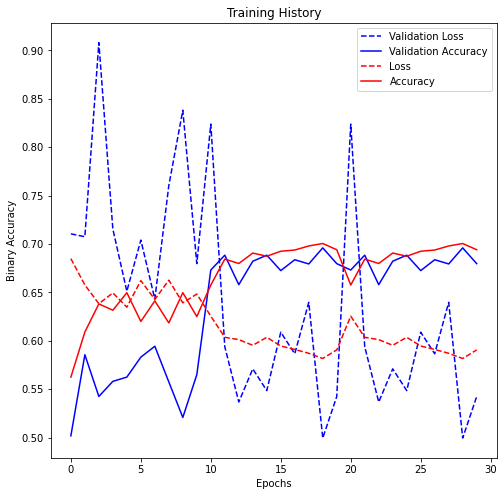

In [13]:
plt.figure(figsize=(8,8))
plt.plot(history['val_loss'], 'b--', label='Validation Loss')
plt.plot(history['val_binary_accuracy'], 'b', label='Validation Accuracy')
plt.plot(history['loss'], 'r--', label='Loss')
plt.plot(history['binary_accuracy'], 'r', label='Accuracy')
plt.title('Training History')
plt.xlabel('Epochs')
plt.ylabel('Binary Accuracy')
plt.legend()

plt.savefig('training_history.png', dpi=160)
plt.show()

## Load Both Models

Here we want to choose the one which performs better on the test set as our designated model for the validation set. The reason for the comparison is the fact that the testing process during training is itself subject to random sampling of the test set so it's possible that the best performance on the test set came more from the choice of test set rather than the superiority of the model. 

In [23]:
val_model = load_model(val_path)
train_model = load_model(train_path)

## Choose a Preferred Model for Validation

We saved two models as we went along since both are training and validation sets were randomly selected (ie: we never trained or validated on the exact same set of data), so we mainly need to make sure that one model is not notably worse than the other. 

In [35]:
test_gen.reset()
val_test_preds = val_model.predict(val_test_gen, verbose=True)

test_gen.reset()
train_test_preds = train_model.predict(val_test_gen, verbose=True)

pickle.dump(val_test_preds, open('val_test_preds.bak', 'wb'))
pickle.dump(train_test_preds, open('train_test_preds.bak', 'wb'))

213/213 [==============================] - 117s 552ms/step


In [ ]:
val_test_preds = pickle.load(open('val_test_preds.bak', 'rb'))
train_test_preds = pickle.load(open('train_test_preds.bak', 'rb'))

In [36]:
thresholds = np.arange(0.1, 1.0, 0.1)
test_y = test_data['Pneumonia_Like']

val_test_acc_reports = [classification_report(test_y, val_test_preds > thresh, output_dict=True) for thresh in thresholds]
train_test_acc_reports = [classification_report(test_y, train_test_preds > thresh, output_dict=True) for thresh in thresholds]

In [126]:
val_fpr, val_tpr, val_thresh = roc_curve(test_y, val_test_preds)
train_fpr, train_tpr, train_thresh = roc_curve(test_y, train_test_preds)

val_test_auc = auc(val_fpr, val_tpr)
train_test_auc = auc(train_fpr, train_tpr)

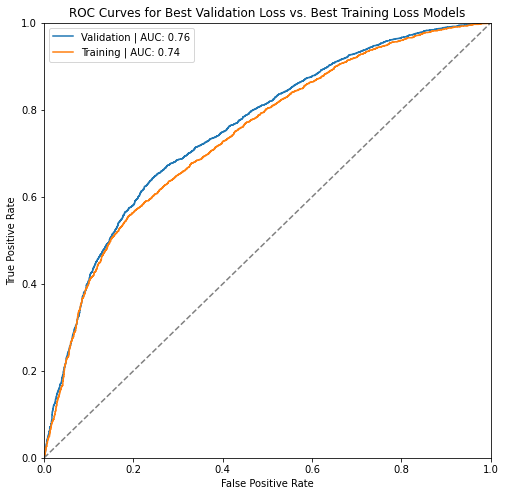

In [127]:
plt.figure(figsize=(8,8))
plt.title("ROC Curves for Best Validation Loss vs. Best Training Loss Models")
plt.plot(val_fpr, val_tpr, label="Validation | AUC: %0.2f" % val_test_auc)
plt.plot(train_fpr, train_tpr, label="Training | AUC: %0.2f" % train_test_auc)
plt.plot([0,1], [0,1], color='gray', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.xlim([0, 1.0])
plt.ylim([0, 1.0])
plt.legend()

The model with the lowest validation loss does beat out the model with the lowest training loss, though they are similar. 

## Choose a Preferred Model for Validation

In [24]:
model = val_model

In [68]:
val_preds = model.predict(val_gen, verbose = True)

pickle.dump(val_preds, open('val_preds.bak', 'wb'))

518/518 [==============================] - 301s 582ms/step


### Optional: Load From Saved Predictions

This saves GPU time if we simply want to analyze the predictions later

In [32]:
val_preds = pickle.load(open('val_preds.bak', 'rb'))

In [33]:
val_Y = val_data["Pneumonia_Like"].astype(int)

In [34]:
preds = val_preds

## ROC Curve

In [35]:
fpr, tpr, thresh = roc_curve(val_Y, preds)
val_auc = auc(fpr, tpr)

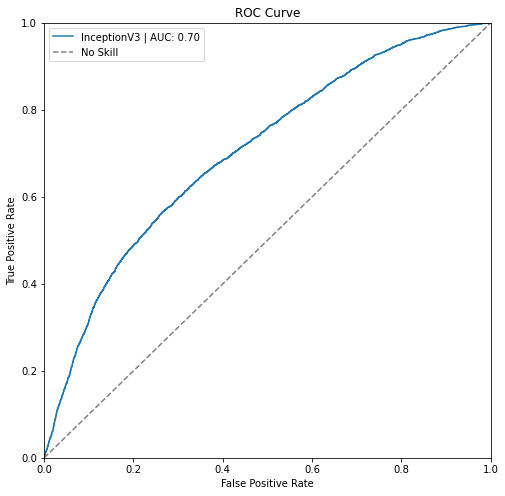

In [36]:
plt.figure(figsize=(8,8))
plt.title("ROC Curve")
plt.plot(fpr, tpr, label="InceptionV3 | AUC: %0.2f" % val_auc)
plt.plot([0,1], [0,1], label='No Skill', color='gray', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.xlim([0, 1.0])
plt.ylim([0, 1.0])
plt.legend()

plt.savefig('roc_curve.png')
plt.show()

## Precision-Recall Curve

In [37]:
prec, recall, thresh = precision_recall_curve(val_Y, preds)
no_skill = sum(val_Y == 1) / len(val_Y)

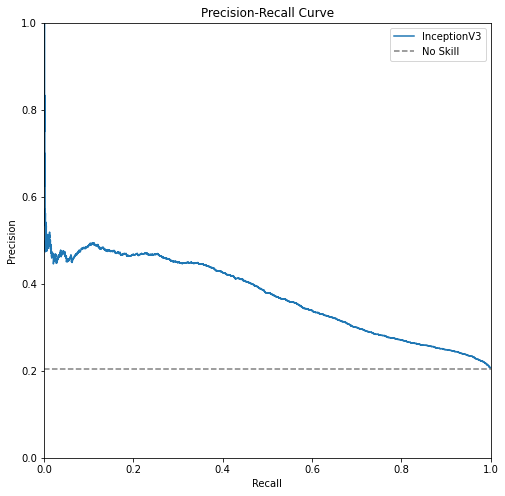

In [38]:
plt.figure(figsize=(8,8))
plt.title("Precision-Recall Curve")
plt.plot(recall, prec, label='InceptionV3')
plt.plot([0,1], [no_skill, no_skill], label='No Skill', color='gray', linestyle='--')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.xlim([0, 1.0])
plt.ylim([0, 1.0])
plt.legend()

plt.savefig('pr_curve.png')
plt.show()

## Choosing a Threshold

In [94]:
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

reports = {}

for val in thresholds:
    reports[val] = classification_report(val_Y, preds > val, output_dict=True)

In [104]:
pos_precision = [reports[t]['1']['precision'] for t in thresholds]
neg_precision = [reports[t]['0']['precision'] for t in thresholds]
pos_recall = [reports[t]['1']['recall'] for t in thresholds]
neg_recall = [reports[t]['0']['recall'] for t in thresholds]
pos_f1 = [reports[t]['1']['f1-score'] for t in thresholds]
weighted_f1 = [reports[t]['weighted avg']['f1-score'] for t in thresholds]
accuracy = [reports[t]['accuracy'] for t in thresholds]

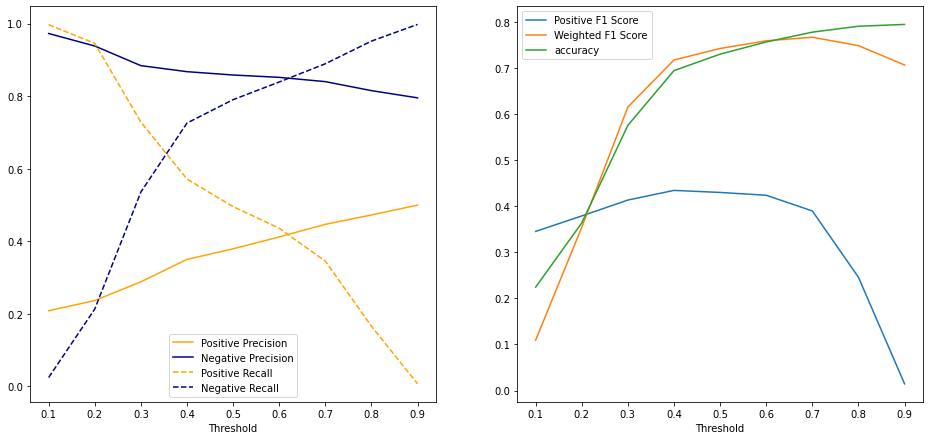

In [118]:
plt.figure(figsize=(16, 16))

plt.subplot(2, 2, 1)
plt.plot(thresholds, pos_precision, label='Positive Precision', color='orange')
plt.plot(thresholds, neg_precision, label='Negative Precision', color='navy')
plt.plot(thresholds, pos_recall, label='Positive Recall', color='orange', linestyle='--')
plt.plot(thresholds, neg_recall, label='Negative Recall', color='navy', linestyle='--')
plt.xlabel('Threshold')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(thresholds, pos_f1, label='Positive F1 Score')
plt.plot(thresholds, weighted_f1, label='Weighted F1 Score')
plt.plot(thresholds, accuracy, label='accuracy')
plt.xlabel('Threshold')
plt.legend()

In [119]:
reports[0.2]

{'0': {'precision': 0.9385847797062751,
  'recall': 0.2135479951397327,
  'f1-score': 0.34793367978223216,
  'support': 13168},
 '1': {'precision': 0.2369584438549956,
  'recall': 0.9458823529411765,
  'f1-score': 0.3789771388168749,
  'support': 3400},
 'accuracy': 0.3638338966682762,
 'macro avg': {'precision': 0.5877716117806353,
  'recall': 0.5797151740404546,
  'f1-score': 0.36345540929955356,
  'support': 16568},
 'weighted avg': {'precision': 0.7946006209729125,
  'recall': 0.3638338966682762,
  'f1-score': 0.35430425925578274,
  'support': 16568}}

In [120]:
reports[0.3]

{'0': {'precision': 0.8844756296203483,
  'recall': 0.5360722964763062,
  'f1-score': 0.6675492931107854,
  'support': 13168},
 '1': {'precision': 0.28857575404681496,
  'recall': 0.7288235294117648,
  'f1-score': 0.4134479018937182,
  'support': 3400},
 'accuracy': 0.5756277160791888,
 'macro avg': {'precision': 0.5865256918335816,
  'recall': 0.6324479129440355,
  'f1-score': 0.5404985975022518,
  'support': 16568},
 'weighted avg': {'precision': 0.762188112904389,
  'recall': 0.5756277160791888,
  'f1-score': 0.6154039086263559,
  'support': 16568}}

In [121]:
reports[0.4]

{'0': {'precision': 0.867864597513386,
  'recall': 0.726230255164034,
  'f1-score': 0.7907553644519785,
  'support': 13168},
 '1': {'precision': 0.350333393404217,
  'recall': 0.571764705882353,
  'f1-score': 0.43446195105598395,
  'support': 3400},
 'accuracy': 0.6945316272332207,
 'macro avg': {'precision': 0.6090989954588015,
  'recall': 0.6489974805231935,
  'f1-score': 0.6126086577539812,
  'support': 16568},
 'weighted avg': {'precision': 0.7616594976841262,
  'recall': 0.6945316272332207,
  'f1-score': 0.7176386572123369,
  'support': 16568}}

## Chosen Threshold

There are several ways to approach this however given the cirucmstances I would choose the 0.2 threshold. It generates a lot of false positives--roughly 3 times as many as true positives--but it has a recall of 94.6% of our positive class. It also has a recall of 21.3% on the negative class with ~94% accuracy.

In other words at this threshold value the algorithm would rarely miss an image that actually contained a pneumonia-like symptom, while at the same time confidently dismissing ~20% of the negative-class images. Since the non-pneumonialike images make up the bulk of the data this 20% is a notable reduction of workload.

In [122]:
## Just save model architecture to a .json:

model_json = val_model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)